# Random Forest Regressor
In this Notebook, Grant walks through the setup, configuration, and analysis of the academic data set using a Random Forest Regressor Model.

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV,RandomizedSearchCV
import numpy as np
from matplotlib import pyplot as plt
#from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import shap


Random Forest Regressor Model Data Preparation
We load the academic Data Set.

We also review the shape of the data set and the data types of the features.

In [50]:
#load dat aset from csv source file
data_set = pd.read_csv('DataSets/RawDataWithStudentsRemoved.csv')

print(data_set.head())

#review data set structure
data_set.dtypes
print(data_set.shape)

#remove null term GPA from data set
data_set = data_set.dropna(subset = ['TermGPA'])
print(data_set.shape)

   FakeIdentifier  Age  Gender PrimaryMilitaryAffiliation AcademicCareer  \
0               1   18  Female    No Military Affiliation  Undergraduate   
1               2   72    Male    No Military Affiliation            Law   
2               3   26    Male    No Military Affiliation       Graduate   
3               4   47  Female                    Veteran       Graduate   
4               5   45    Male    No Military Affiliation  Undergraduate   

                          College  NumberofClassesEnrolled  TermGPA  \
0              College of Science                        4     3.75   
1   James E Rogers College of Law                        3     4.00   
2          College of Engineering                        2      NaN   
3       Coll of Ag Life & Env Sci                        2     4.00   
4  College of Information Science                        2     2.00   

   CumulativeGPA  UnitsPassedincludedinGPA  UnitsPassednotincludedinGPA  \
0          3.636                         

In [51]:
#Filter the data set to one College if needed

data_set = data_set[data_set['College'] == 'College of Engineering']

In [ ]:
#viewing basic summary stats of the features

print(data_set['TermGPA'].median())


int64
3.75


Let's also explore feature correlations to see if any of our non-target features correlate with each other. 

We may want to remove highly features which correlate with other non-target features

In [ ]:
feature_corr_data_set = data_set.corr(numeric_only=True)

print(feature_corr_data_set)

We split the data set into a train and a test set (80/20) using the same random seed (698).
We decide which features to include and which to drop before training the model.

 We also must encode the remaining categorical features.

In [52]:
# Y target column
target_column = 'TermGPA'
test_percent = 0.20

#x_columns_to_drop = ['FakeIdentifier' , 'TermGPA']

#data set dropping the target feature
x_features = data_set.drop(['FakeIdentifier' ,
                            # 'College',
                             #'PrimaryMilitaryAffiliation',
                             'CumulativeGPA',
                            # 'AcademicYear',
                            # 'Gender',
                            # 'AcademicCareer',
                             'UnitsPassedincludedinGPA',
                             'UnitsPassednotincludedinGPA',
                            # 'UAFullTimePartTime',
                            # 'NumberofClassesEnrolled',
                            # 'AcademicLevelEndofTerm',
                             'TermGPA'],
                               axis = 1)


#encoding categorical features
columns_to_encode = ['Gender',
                     'PrimaryMilitaryAffiliation',
                     'AcademicCareer',
                     'College',
                     'UAFullTimePartTime',
                     'AcademicLevelEndofTerm',
                     'FirstGenerationFlag' 
                          ]


y_target = data_set[target_column]


#split the data into a 80/20 train test split using the same random seed for consistency
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size = test_percent, random_state = 698) 

#encode categorical features, and drop one level to avoid multicolinearity
x_train_encoded = pd.get_dummies(x_train,
                                  columns=columns_to_encode,
                                    drop_first=True,
                                      dtype = int)
x_test_encoded = pd.get_dummies(x_test,
                                 columns=columns_to_encode,
                                 drop_first=True,
                                   dtype = int)
# restore missing features after encoding
x_train_features_encoded_cols = x_train_encoded.columns
x_test_encoded = x_test_encoded.reindex(columns=x_train_features_encoded_cols, fill_value=0)


In [ ]:
# Review Features before training
print(x_features)

print(x_train_encoded.columns)

print(x_test_encoded.columns)

       Age  Gender PrimaryMilitaryAffiliation AcademicCareer  \
87      29    Male                    Veteran       Graduate   
120     25    Male    No Military Affiliation       Graduate   
136     31    Male    No Military Affiliation       Graduate   
152     26    Male    No Military Affiliation       Graduate   
158     42  Female    No Military Affiliation       Graduate   
...    ...     ...                        ...            ...   
63206   41  Female    No Military Affiliation       Graduate   
63232   36    Male    No Military Affiliation       Graduate   
63273   27    Male    No Military Affiliation       Graduate   
63337   46    Male                    Veteran       Graduate   
63352   36    Male            Other Dependent  Undergraduate   

                      College  NumberofClassesEnrolled  \
87     College of Engineering                        3   
120    College of Engineering                        2   
136    College of Engineering                        1   

 RF Regressor model parameters are defined here.

In [53]:
#making the RF Regressor Model

metric = mean_squared_error
metric_name = "Mean Squared Error"
rfr_depth = 25
rfr_max_features = 0.35 # None, sqrt or log2
rfr_min_sample_split = 12
rfr_min_samples_leaf = 9
rfr_criterion = 'squared_error' #criterion{“squared_error”, “absolute_error”, “friedman_mse”, “poisson”}, default=”squared_error”
rfr_estimators = 200

model = RandomForestRegressor(n_estimators = rfr_estimators,
                               criterion = rfr_criterion,
                                 max_features = rfr_max_features,
                                 min_samples_leaf= rfr_min_samples_leaf,
                                    min_samples_split=rfr_min_sample_split,
                                      max_depth = rfr_depth,
                                          random_state=698)



In [4]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

# Parameter opimization
We can utilize randomized search to uncover the optimal set of parameters for  our model.
We want to find better values for the number of estimators, the number of features in include, and the best  thresholds for making splits and leaves in the decision trees. 

In [5]:
#Parameter optimization

#for randomsearch to find a better set of parameters--not used in final run, hardcoded parm instead
rfr_optimized = RandomForestRegressor(random_state = 698)

param_grid = {
    'n_estimators':randint(low = 50, high = 300),
    'max_depth':randint(low=5, high=50),
    'min_samples_split':randint(low=2, high=16),
    'min_samples_leaf':randint(low=1, high=20),
    'max_features':uniform(loc=0.1, scale=0.9),
   
}


# Perform Random Search
random_search = RandomizedSearchCV(rfr_optimized, param_grid, cv=5, n_jobs = 2, scoring='neg_mean_squared_error', random_state= 698)
random_search.fit(x_train_encoded, y_train)

# Get the best parameters and model
best_CV_params = random_search.best_params_
best_CV_model = random_search.best_estimator_

print(f"{best_CV_params} are the best random cv parms" )
print(best_CV_model)



{'max_depth': 27, 'max_features': 0.2792263806438744, 'min_samples_leaf': 9, 'min_samples_split': 12, 'n_estimators': 230} are the best random cv parms
RandomForestRegressor(max_depth=27, max_features=0.2792263806438744,
                      min_samples_leaf=9, min_samples_split=12,
                      n_estimators=230, random_state=698)


{'max_depth': 33, 'max_features': 0.387746596652107, 'min_samples_leaf': 9, 'min_samples_split': 13, 'n_estimators': 198} are the best random cv parms
RandomForestRegressor(max_depth=33, max_features=0.387746596652107,
                      min_samples_leaf=9, min_samples_split=13,
                      n_estimators=198, random_state=698)

                      {'max_depth': 27, 'max_features': 0.2792263806438744, 'min_samples_leaf': 9, 'min_samples_split': 12, 'n_estimators': 230} are the best random cv parms
RandomForestRegressor(max_depth=27, max_features=0.2792263806438744,
                      min_samples_leaf=9, min_samples_split=12,
                      n_estimators=230, random_state=698)

# Evaluation

We review accuracy metrics from a cross-fold validation, as well as the accuracy of the model run on our test set.

Wel also produce both the Feature Importances and the Permutation Importances for the model. 

In [18]:
#Adding kFold Cross validation--------------------------
kfold = KFold(n_splits=5, shuffle=True, random_state=698)


#for kfold accuracy scores
cv_scores = cross_val_score(model, x_train_encoded, y_train, cv=kfold, scoring='neg_mean_squared_error')

#review KFold Scores in the output (5-fold for our model)
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [-0.39286605 -0.40539272 -0.40382745 -0.39670704 -0.41907263]
Mean cross-validation score: -0.40357317958538036


In [54]:
#fit the model
model.fit(x_train_encoded, y_train)

# Predict using test data
y_pred = model.predict(x_test_encoded) 

    # compare prediction to actual dev/test data
score = metric(y_test, y_pred)
print(f"{metric_name} on test set: {score:.4f}") #0.2409

r_squared = r2_score(y_test, y_pred)
print(f"r_squared on test set: {r_squared:.4f}") #0.8237

Mean Squared Error on test set: 1.1665
r_squared on test set: 0.1239


We will look at Feature and Permutation Importance for our RF model.

In [24]:
#feature importances:
feature_importances = model.feature_importances_ 
print(feature_importances)
    
    #put feature importances in a data frame
feature_names = x_train_encoded.columns 
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by = 'Importance', ascending = False)
pd.set_option('display.max_rows', None)
print(feature_importance_df)

[1.76512643e-01 6.57194524e-02 7.20308817e-03 8.15728462e-02
 2.80822103e-02 7.74526559e-05 1.95615372e-03 1.40944757e-03
 2.47319988e-02 8.15552032e-03 1.11660047e-03 3.08290307e-05
 1.03504731e-02 3.48976523e-03 1.62143124e-01 9.83631138e-03
 2.20832278e-04 1.02132205e-03 3.40528786e-03 1.08390246e-03
 7.06207912e-03 2.10132016e-02 0.00000000e+00 3.90949355e-04
 9.06086654e-03 1.19440750e-02 1.61231913e-02 4.25015959e-03
 1.95307038e-02 2.02429055e-03 5.17495446e-04 3.33592339e-03
 1.84701011e-02 2.69426338e-03 1.37210926e-02 8.81474981e-02
 3.76446238e-02 3.98575608e-03 7.95335278e-02 2.89542921e-02
 4.34766490e-02]
                                              Feature  Importance
0                                                 Age    0.176513
14                       AcademicCareer_Undergraduate    0.162143
35                    AcademicLevelEndofTerm_Graduate    0.088147
3                                        AcademicYear    0.081573
38                      AcademicLevelEndofT

In [55]:
#permutation importance

result = permutation_importance(model, x_test_encoded, y_test, scoring = 'neg_mean_squared_error', n_repeats=10, random_state=698, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

permutation_importances = pd.Series(result.importances_mean[sorted_idx], index=x_test_encoded.columns[sorted_idx]).sort_values(ascending=False)
print("\nPermutation Importance:")
print(permutation_importances)


Permutation Importance:
AcademicLevelEndofTerm_Graduate                            0.063592
AcademicCareer_Undergraduate                               0.057849
FirstGenerationFlag_Y                                      0.033963
AcademicYear                                               0.022801
AcademicLevelEndofTerm_Senior                              0.021402
PrimaryMilitaryAffiliation_No Military Affiliation         0.012553
Age                                                        0.011164
UAFullTimePartTime_P                                       0.004662
NumberofClassesEnrolled                                    0.002842
AcademicLevelEndofTerm_Sophomore                           0.000813
PrimaryMilitaryAffiliation_Veteran                         0.000680
Gender_Male                                                0.000310
PrimaryMilitaryAffiliation_Unknown Military Affiliation    0.000000
PrimaryMilitaryAffiliation_Guard Reserve                   0.000000
PrimaryMilitaryAffiliat

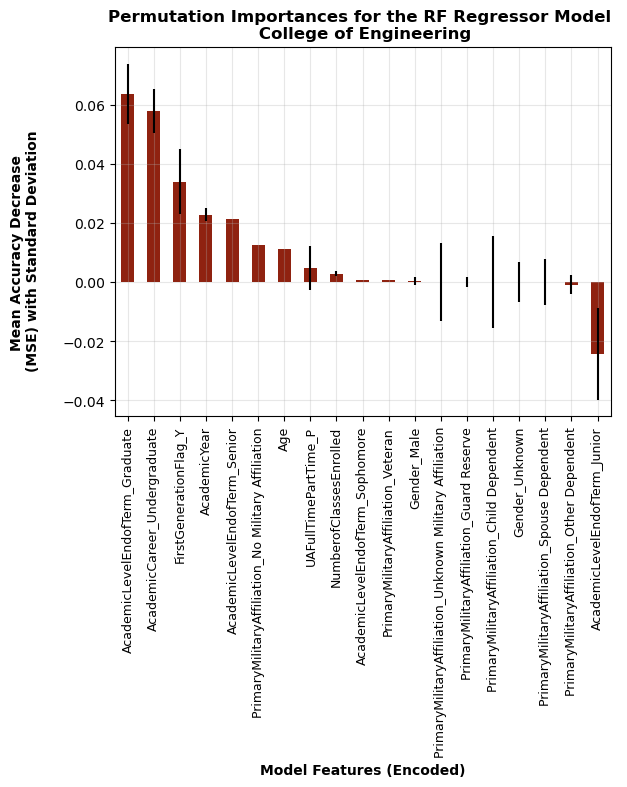

In [62]:
#generate a plot of the Permutation importances (mean and stdev)

fig, ax = plt.subplots()
permutation_importances.plot.bar(yerr=result.importances_std, ax=ax, color = '#8F2210')
ax.set_title("Permutation Importances for the RF Regressor Model \n College of Engineering", fontweight = 'bold')
ax.set_xlabel("Model Features (Encoded)", fontweight = 'bold')
ax.set_ylabel("Mean Accuracy Decrease \n(MSE) with Standard Deviation", fontweight = 'bold')
ax.yaxis.set_label_coords(-0.15, 0.45)
plt.xticks(fontsize=9)
ax.grid(alpha = 0.3)
#fig.tight_layout()
plt.show()

In [63]:
#shap values

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test_encoded)

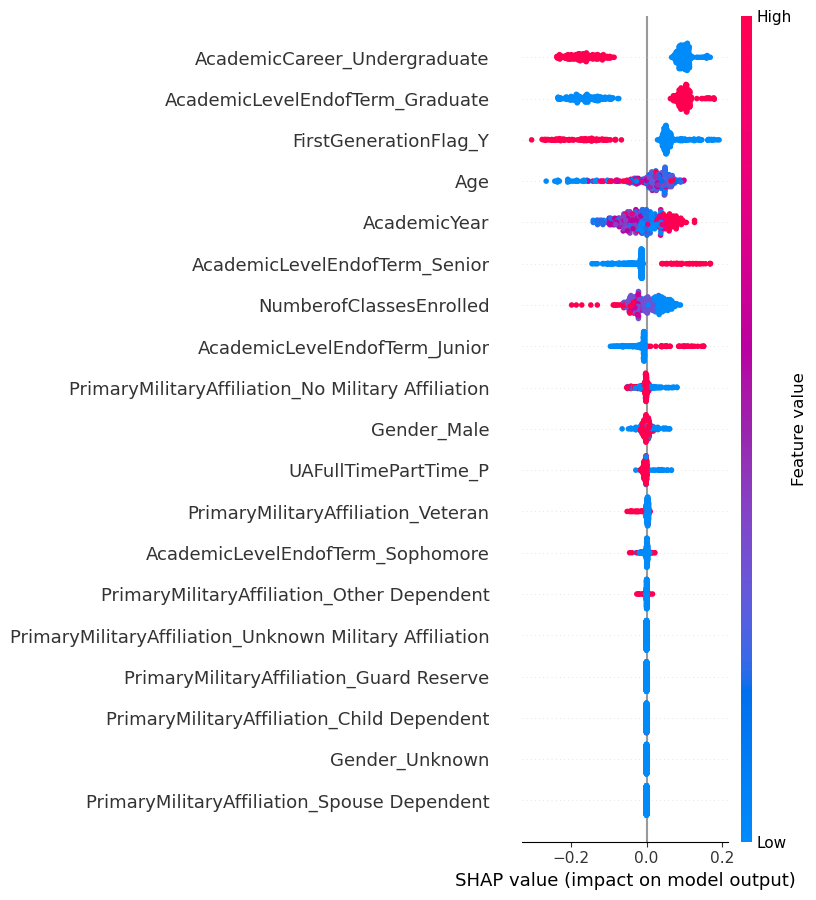

TypeError: force() missing 1 required positional argument: 'base_value'

In [ ]:
#visualize the SHAP values fpr RFR
shap.summary_plot(shap_values, x_test_encoded, max_display = 25)

# plt.title("SHAP Summary Plot")
plt.show()

In [ ]:
shap_values_instance = explainer.shap_values(x_test_encoded.iloc[[0]])

shap.force_plot(explainer.expected_value, shap_values_instance, x_test_encoded.iloc[[0]])
plt.show()

In [ ]:
#feature correlations

x_feature_correlation = x_train_encoded.corr()
target_corr = pd.concat([x_train_encoded, y_train], axis = 1).corr()
#print(target_corr)
#-0.15 corr for first gen and term GPA

